In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

In [2]:
df_fam_featured = pd.read_csv('../Data_modelo/df_modelo_balanceado.csv')

In [3]:
df_fam_featured = df_fam_featured.rename(columns={'pct_deficientes':'pct_pcd'})

In [4]:
df_fam_featured = df_fam_featured.drop('id_familia', axis=1)

In [5]:
df_fam_featured.columns

Index(['uf_ibge', 'classf', 'cod_local_domic_fam', 'qtd_comodos_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam',
       'cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
       'ind_parc_mds_fam', 'qtde_pessoas', 'dias_cadastramento',
       'dias_atualizacao', 'classe_renda', 'rf_idade', 'rf_trab_principal',
       'rf_com_deficiencia', 'rf_trab_agricultura', 'rf_sexo',
       'rf_curso_frequentou', 'rf_curso_frequenta', 'rf_trabalhou_semana',
       'rf_cor_raca', 'rf_concluiu_curso', 'pct_extrativista',
       'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escolar_nunca_freq_e

In [6]:
df_fam_featured.head()

,uf_ibge,classf,cod_local_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_iluminacao_domic_fam,cod_familia_indigena_fam,ind_familia_quilombola_fam,ind_parc_mds_fam,qtde_pessoas,...,pct_adulto_nunca_freq_escola,pct_escolar_nunca_freq_escola,pct_freq_creche,pct_idosos,pct_pcd,pct_1_infancia,pct_adulto,pct_crianca_adolescente,fam_gpte,ideb_2017_municipio
0,15,1,1.0,2.0,2.0,1.0,2.0,2.0,0.0,3,...,0.333333,0.0,0.0,0.0,0.000,0.000000,0.333333,0.666667,0.0,4.8
1,13,3,1.0,4.0,2.0,1.0,2.0,2.0,0.0,8,...,0.000000,0.0,0.0,0.0,0.375,0.375000,0.250000,0.375000,0.0,4.6
2,29,3,2.0,4.0,2.0,1.0,2.0,2.0,205.0,2,...,0.000000,0.5,0.0,0.0,0.000,0.000000,0.500000,0.500000,1.0,4.0
3,28,3,2.0,5.0,2.0,1.0,2.0,2.0,0.0,2,...,0.000000,0.0,0.0,0.0,0.000,0.500000,0.500000,0.000000,0.0,4.2
4,33,3,1.0,5.0,5.0,1.0,2.0,2.0,0.0,3,...,0.000000,0.0,0.0,0.0,0.000,0.333333,0.666667,0.000000,0.0,4.6


In [7]:
corr_matrix = df_fam_featured.corr()

In [8]:
mask_fam = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

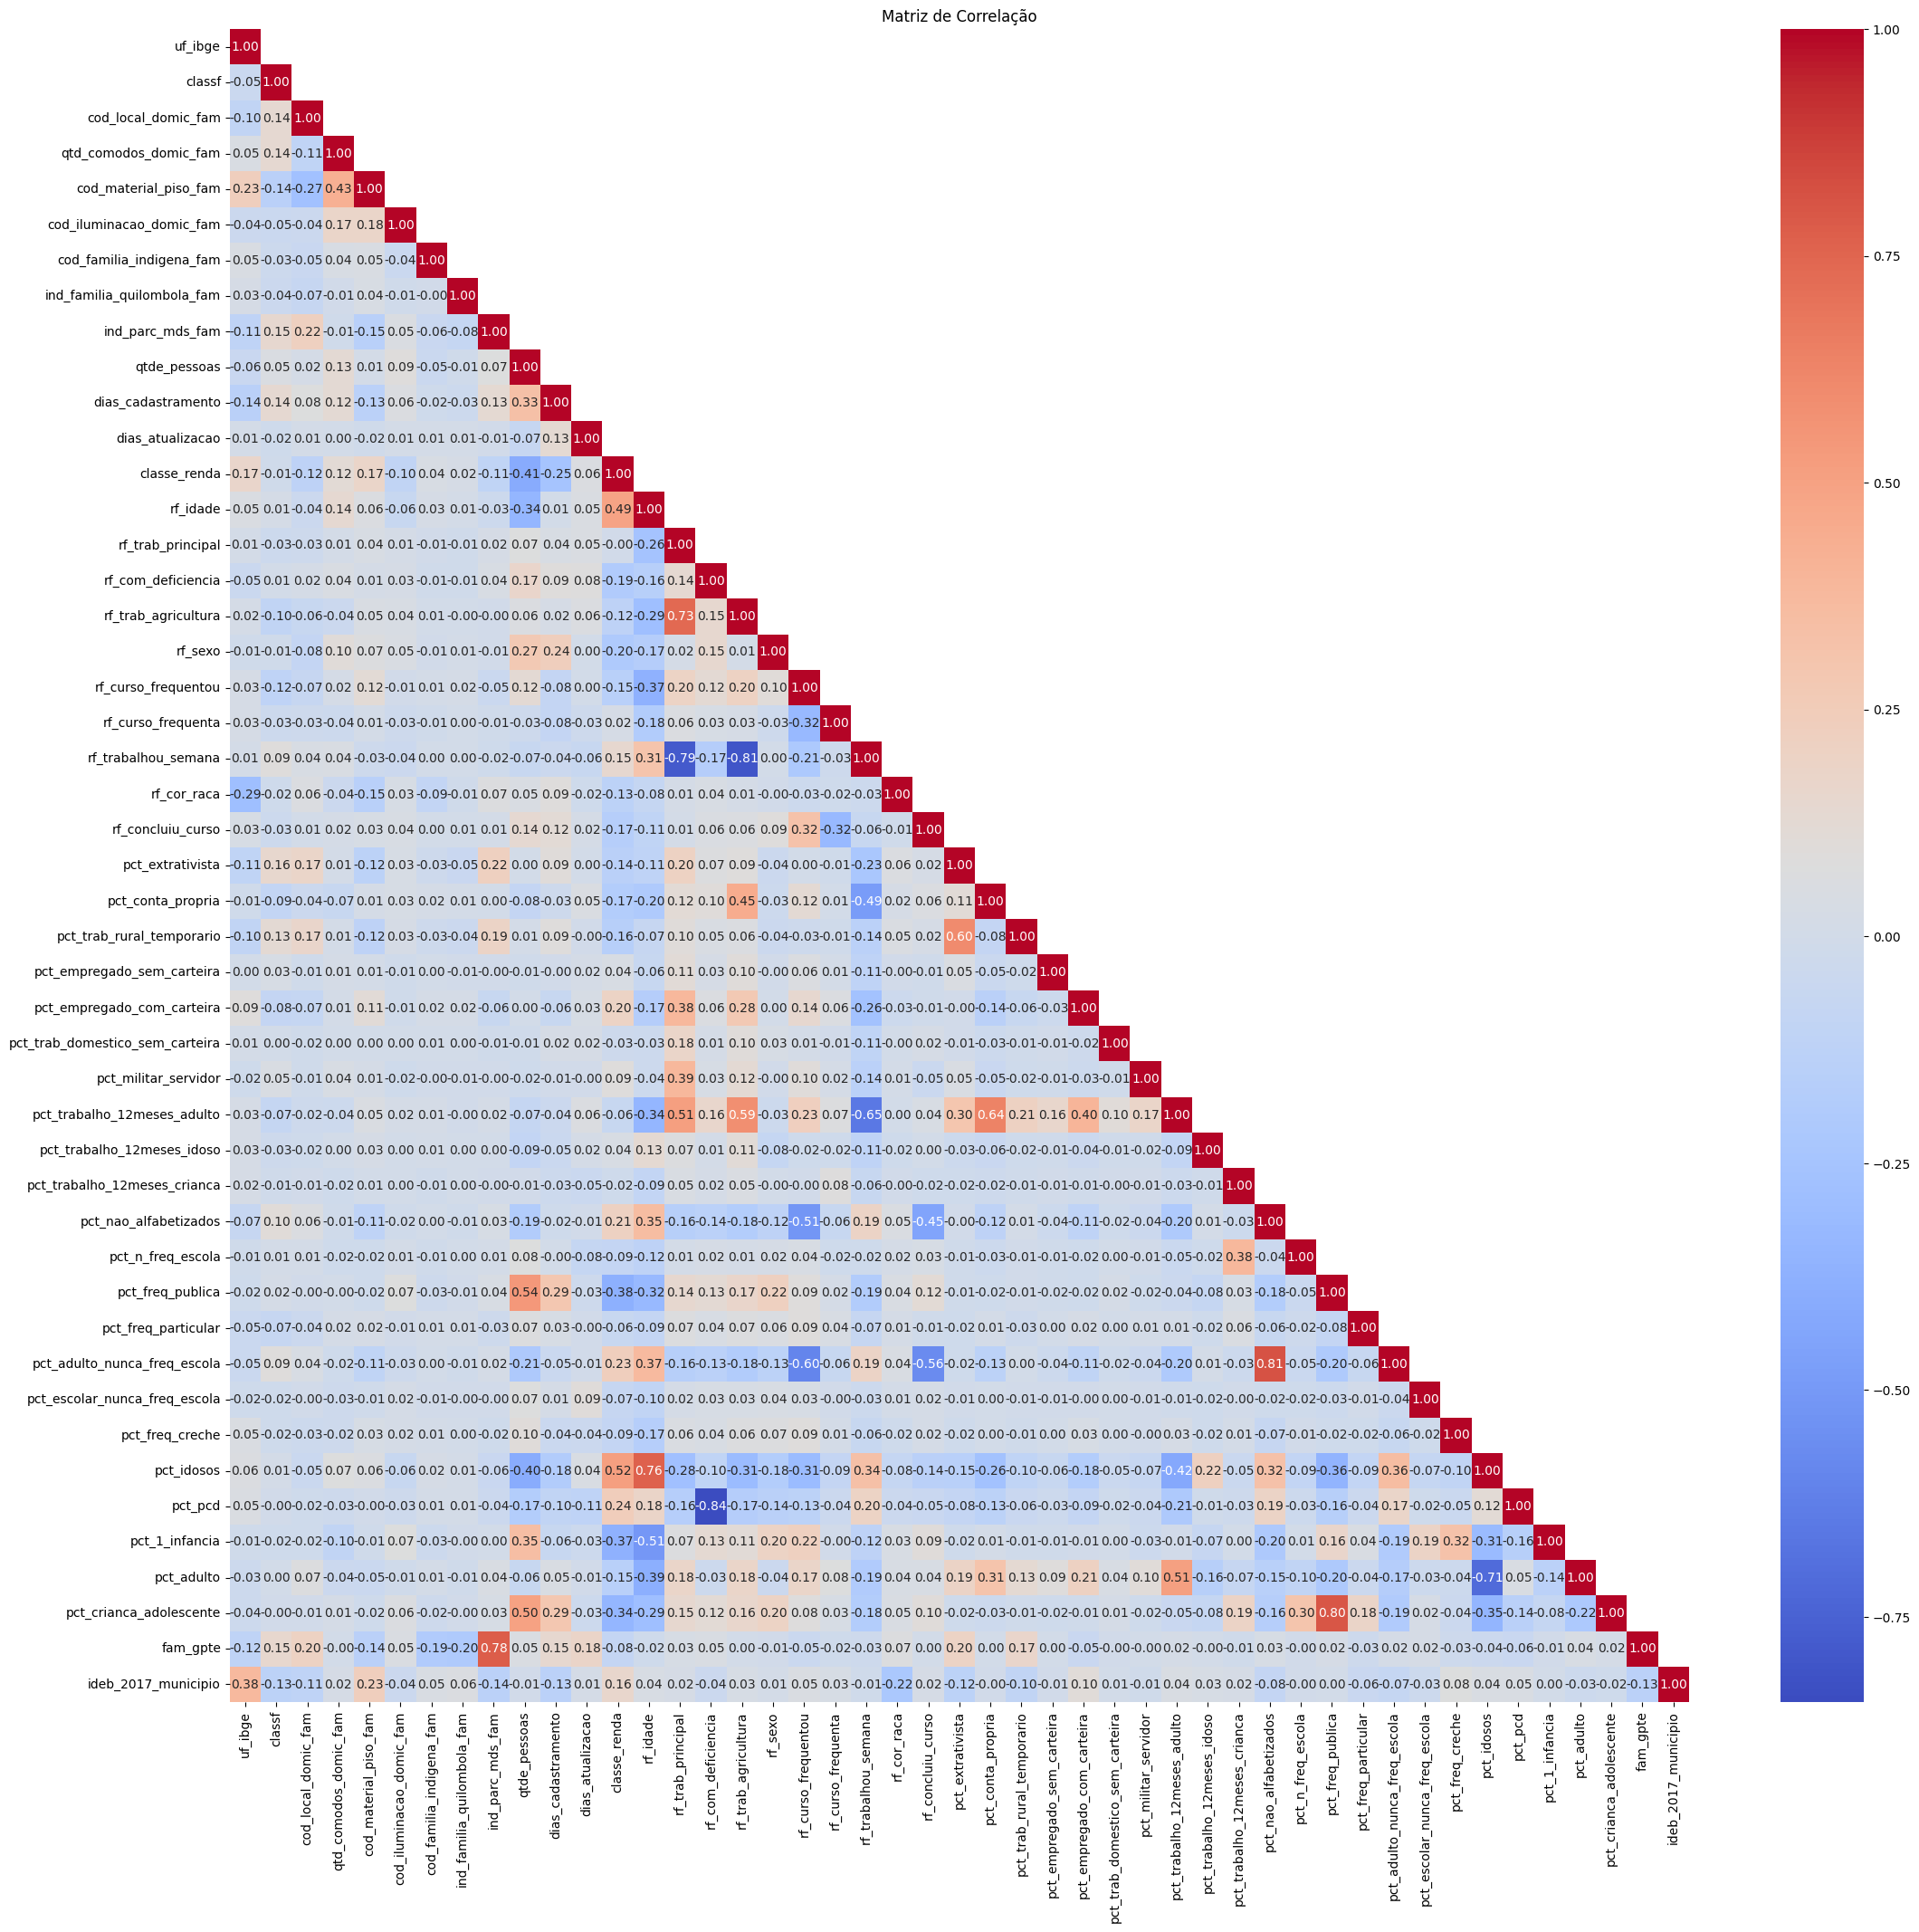

In [9]:
# Verificar a correlação entre as variáveis
plt.figure(figsize=(26, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask_fam)
plt.title('Matriz de Correlação')
plt.show()

In [10]:
# Filtrar as correlações acima de 0.8
corr_threshold = 0.8
high_corr_pairs = []

for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            var1 = corr_matrix.index[i]
            var2 = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]
            high_corr_pairs.append((var1, var2, correlation))

# Mostrar os pares de variáveis com correlação acima de 0.8
for var1, var2, correlation in high_corr_pairs:
    print(f'Variáveis: {var1} e {var2} - Correlação: {correlation:.2f}')

Variáveis: rf_com_deficiencia e pct_pcd - Correlação: -0.84
Variáveis: rf_trab_agricultura e rf_trabalhou_semana - Correlação: -0.81
Variáveis: pct_nao_alfabetizados e pct_adulto_nunca_freq_escola - Correlação: 0.81


In [11]:
# Retirar as variáveis com correlação acima de 0.8
df_fam_featured = df_fam_featured.drop(['rf_com_deficiencia', 'pct_nao_alfabetizados', 'rf_trabalhou_semana'], axis=1)

In [12]:
X = df_fam_featured.drop('classe_renda', axis=1)
y = df_fam_featured['classe_renda']

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96791 entries, 0 to 96790
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   uf_ibge                          96791 non-null  int64  
 1   classf                           96791 non-null  int64  
 2   cod_local_domic_fam              96791 non-null  float64
 3   qtd_comodos_domic_fam            96791 non-null  float64
 4   cod_material_piso_fam            96791 non-null  float64
 5   cod_iluminacao_domic_fam         96791 non-null  float64
 6   cod_familia_indigena_fam         96791 non-null  float64
 7   ind_familia_quilombola_fam       96791 non-null  float64
 8   ind_parc_mds_fam                 96791 non-null  float64
 9   qtde_pessoas                     96791 non-null  int64  
 10  dias_cadastramento               96791 non-null  float64
 11  dias_atualizacao                 96791 non-null  int64  
 12  rf_idade          

In [14]:
min_values = df_fam_featured.min()
max_values = df_fam_featured.max()

# Criar um dataframe para exibir o mínimo e o máximo lado a lado de cada coluna
min_max_df = pd.DataFrame({'Min': min_values, 'Max': max_values})

min_max_df

,Min,Max
uf_ibge,11.0,53.000000
classf,1.0,3.000000
cod_local_domic_fam,1.0,9.000000
qtd_comodos_domic_fam,-1.0,20.000000
cod_material_piso_fam,-1.0,7.000000
cod_iluminacao_domic_fam,-1.0,6.000000
cod_familia_indigena_fam,1.0,2.000000
ind_familia_quilombola_fam,1.0,2.000000
ind_parc_mds_fam,0.0,306.000000
qtde_pessoas,1.0,13.000000


In [15]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        # Fazer o fit nas colunas, mas ignorando os valores -1
        self.scaler_dict = {}
        for col in X.columns:
            mask = X[col] != -1
            if mask.any():  # Verificar se há valores diferentes de -1
                self.scaler_dict[col] = self.scaler.fit(X[col][mask].values.reshape(-1, 1))
        return self

    def transform(self, X):
        # Aplicar a transformação para cada coluna, mantendo -1 inalterado
        X_scaled = X.copy()
        for col in X.columns:
            mask = X[col] != -1
            if col in self.scaler_dict:
                # Converter a coluna para float antes de aplicar a transformação
                X_scaled[col] = X_scaled[col].astype(float)
                X_scaled.loc[mask, col] = self.scaler_dict[col].transform(X[col][mask].values.reshape(-1, 1)).flatten()
        return X_scaled

In [16]:
X.columns

Index(['uf_ibge', 'classf', 'cod_local_domic_fam', 'qtd_comodos_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam',
       'cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
       'ind_parc_mds_fam', 'qtde_pessoas', 'dias_cadastramento',
       'dias_atualizacao', 'rf_idade', 'rf_trab_principal',
       'rf_trab_agricultura', 'rf_sexo', 'rf_curso_frequentou',
       'rf_curso_frequenta', 'rf_cor_raca', 'rf_concluiu_curso',
       'pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_n_freq_escola', 'pct_freq_publica',
       'pct_freq_particular', 'pct_adulto_nunca_freq_escola',
       'pct_escolar_nunca_freq_escola', 'pct_freq_creche', 'pct_idosos',
       'pct_pcd', 'pct_1_infancia', 'pct_adulto', 'p

In [17]:
# Identificar colunas categóricas para One-Hot Encoding
categorical_columns = ['uf_ibge', 'classf', 'cod_local_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam',
       'cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
       'ind_parc_mds_fam', 'rf_trab_principal',
       'rf_trab_agricultura', 'rf_sexo', 'rf_curso_frequentou',
       'rf_curso_frequenta', 'rf_cor_raca', 'rf_concluiu_curso',
       'fam_gpte']
numeric_columns = [col for col in X.columns if col not in categorical_columns]

In [18]:
# Pipeline de pré-processamento com OneHotEncoder para categóricas e CustomScaler para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', CustomScaler(scaler=StandardScaler()), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

In [19]:
# Definir os modelos
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [20]:
# Configurar a busca Bayesiana para os hiperparâmetros
search_spaces = {
    'RandomForest': {
        'n_estimators': (10, 200),
        'max_depth': (1, 20),
        'min_samples_split': (2, 10)
    },
    'XGBoost': {
        'n_estimators': (50, 300),
        'learning_rate': (0.01, 0.2, 'log-uniform'),
        'max_depth': (3, 10)
    },
    'CatBoost': {
        'depth': (4, 10),
        'learning_rate': (0.01, 0.2, 'log-uniform'),
        'iterations': (100, 300)
    }
}

In [21]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Pipeline de pré-processamento
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar o pipeline de pré-processamento
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [23]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Matriz de Confusão - {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [24]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
# Armazenar resultados
best_models = {}

for name, model in models.items():
    print(f'Treinando {name}...')
    opt = BayesSearchCV(model, search_spaces[name], n_iter=10, cv=cv, random_state=42)
    opt.fit(X_train_preprocessed, y_train)
    best_models[name] = opt.best_estimator_
    print(f'Melhores hiperparâmetros para {name}: {opt.best_params_}')
    print(f'Avaliando {name}...')
    y_pred = opt.predict(X_test_preprocessed)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred_top_10, title=name)

Treinando RandomForest...


In [27]:
# Função para obter os nomes das colunas após o ColumnTransformer
def get_feature_names(column_transformer):
    output_features = []
    
    for name, transformer, column in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(column)  # Colunas numéricas mantêm seus nomes
        elif name == 'cat':
            # OneHotEncoder adiciona sufixos para cada valor das variáveis categóricas
            ohe_columns = transformer.get_feature_names_out(column)
            output_features.extend(ohe_columns)
    
    return output_features

In [28]:
# Aplicar o pipeline de pré-processamento
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Obter os nomes das colunas após o pré-processamento
processed_columns = get_feature_names(preprocessor)

Mediana das importâncias para RandomForest: 0.0015644297366118433


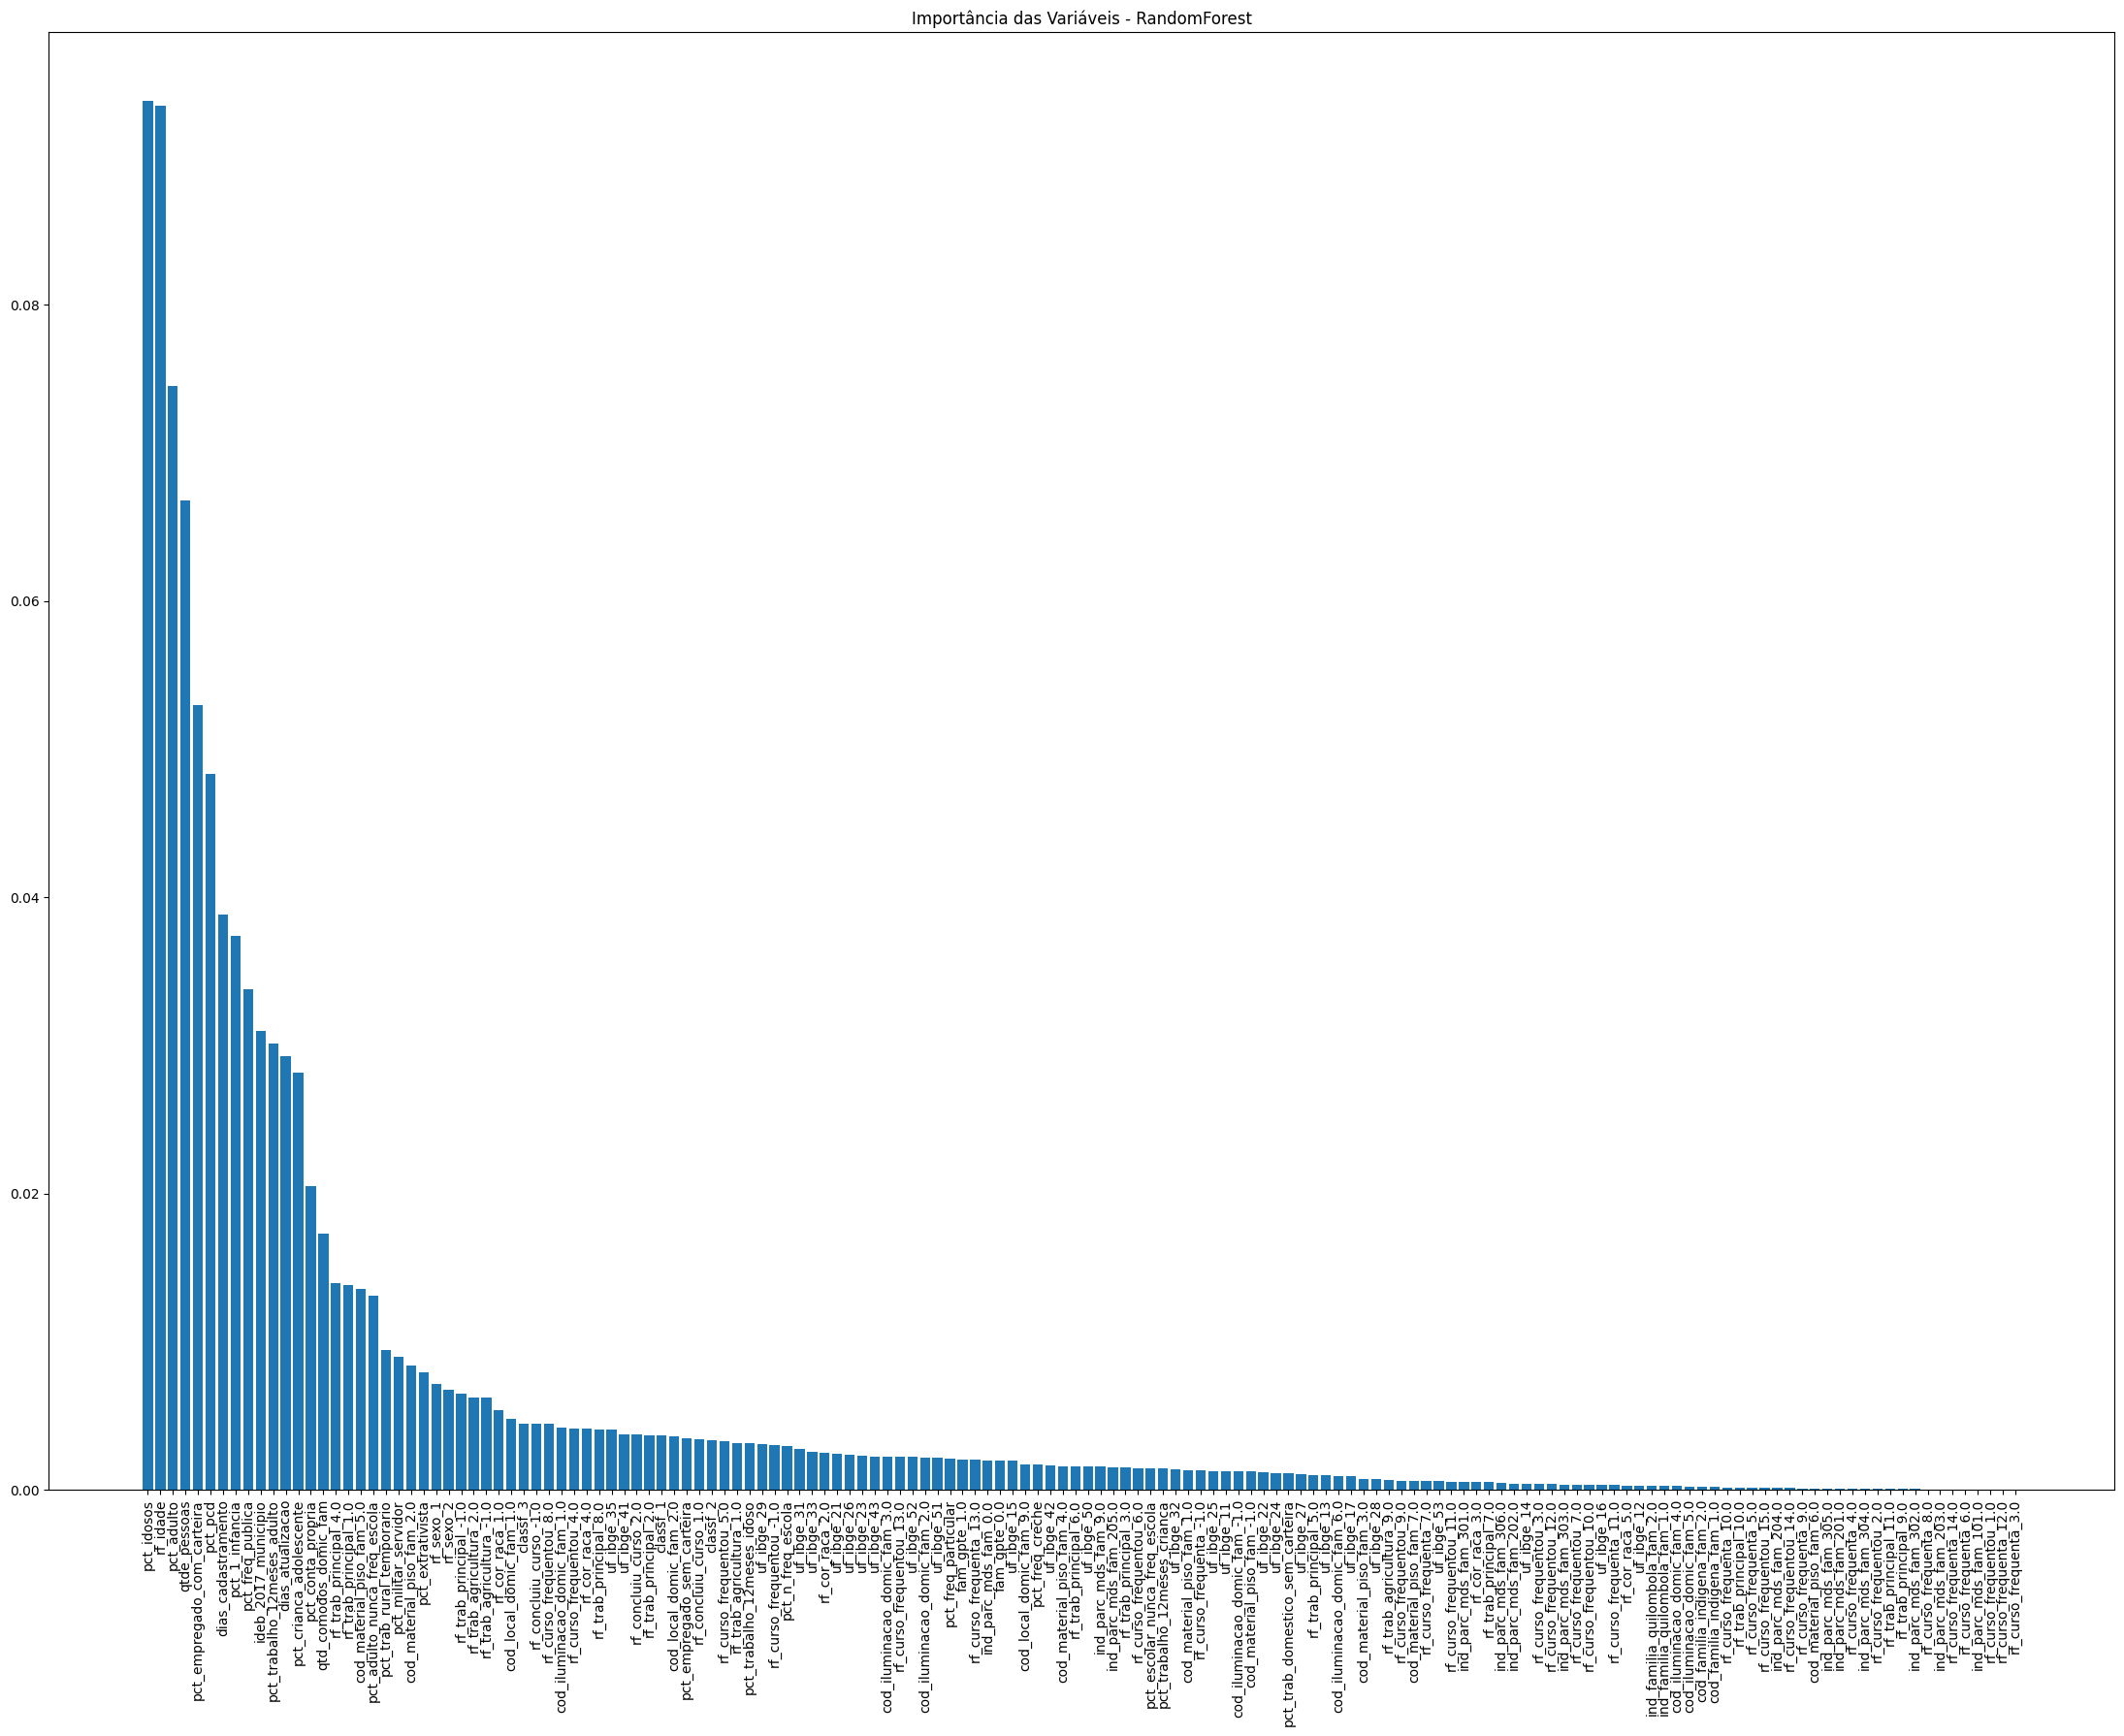

Mediana das importâncias para XGBoost: 0.0028329193592071533


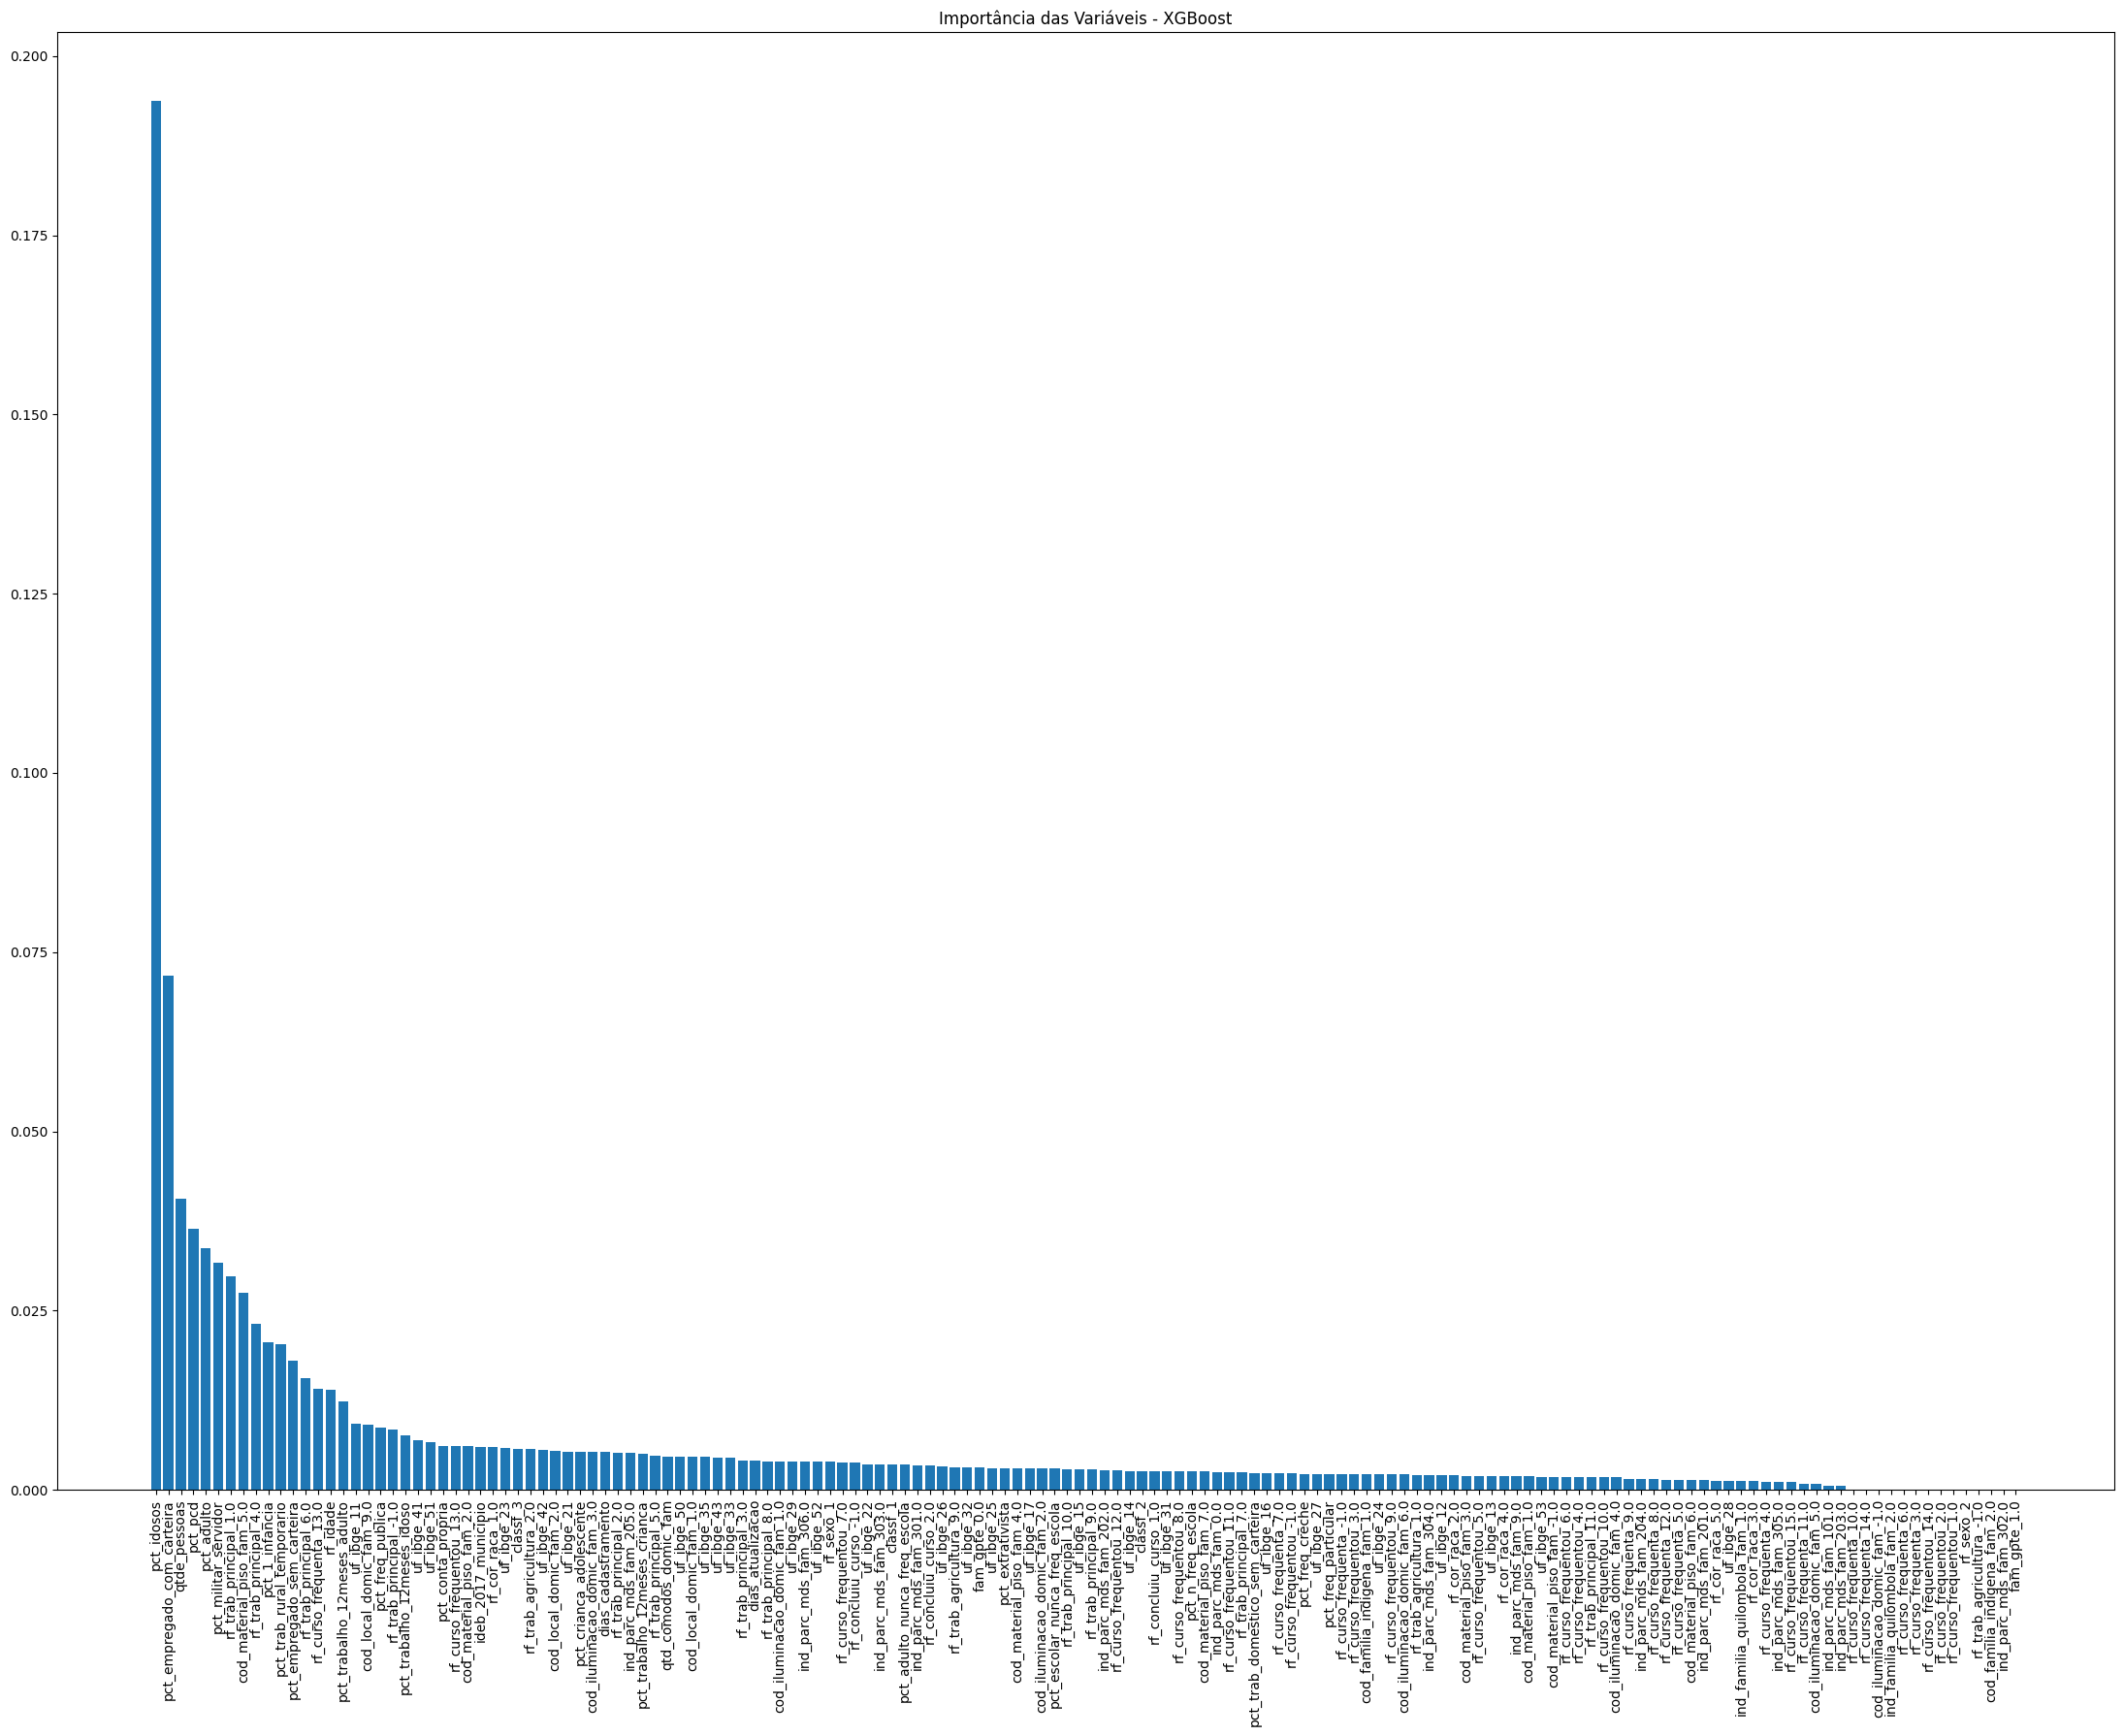

Mediana das importâncias para CatBoost: 0.04253576932432047


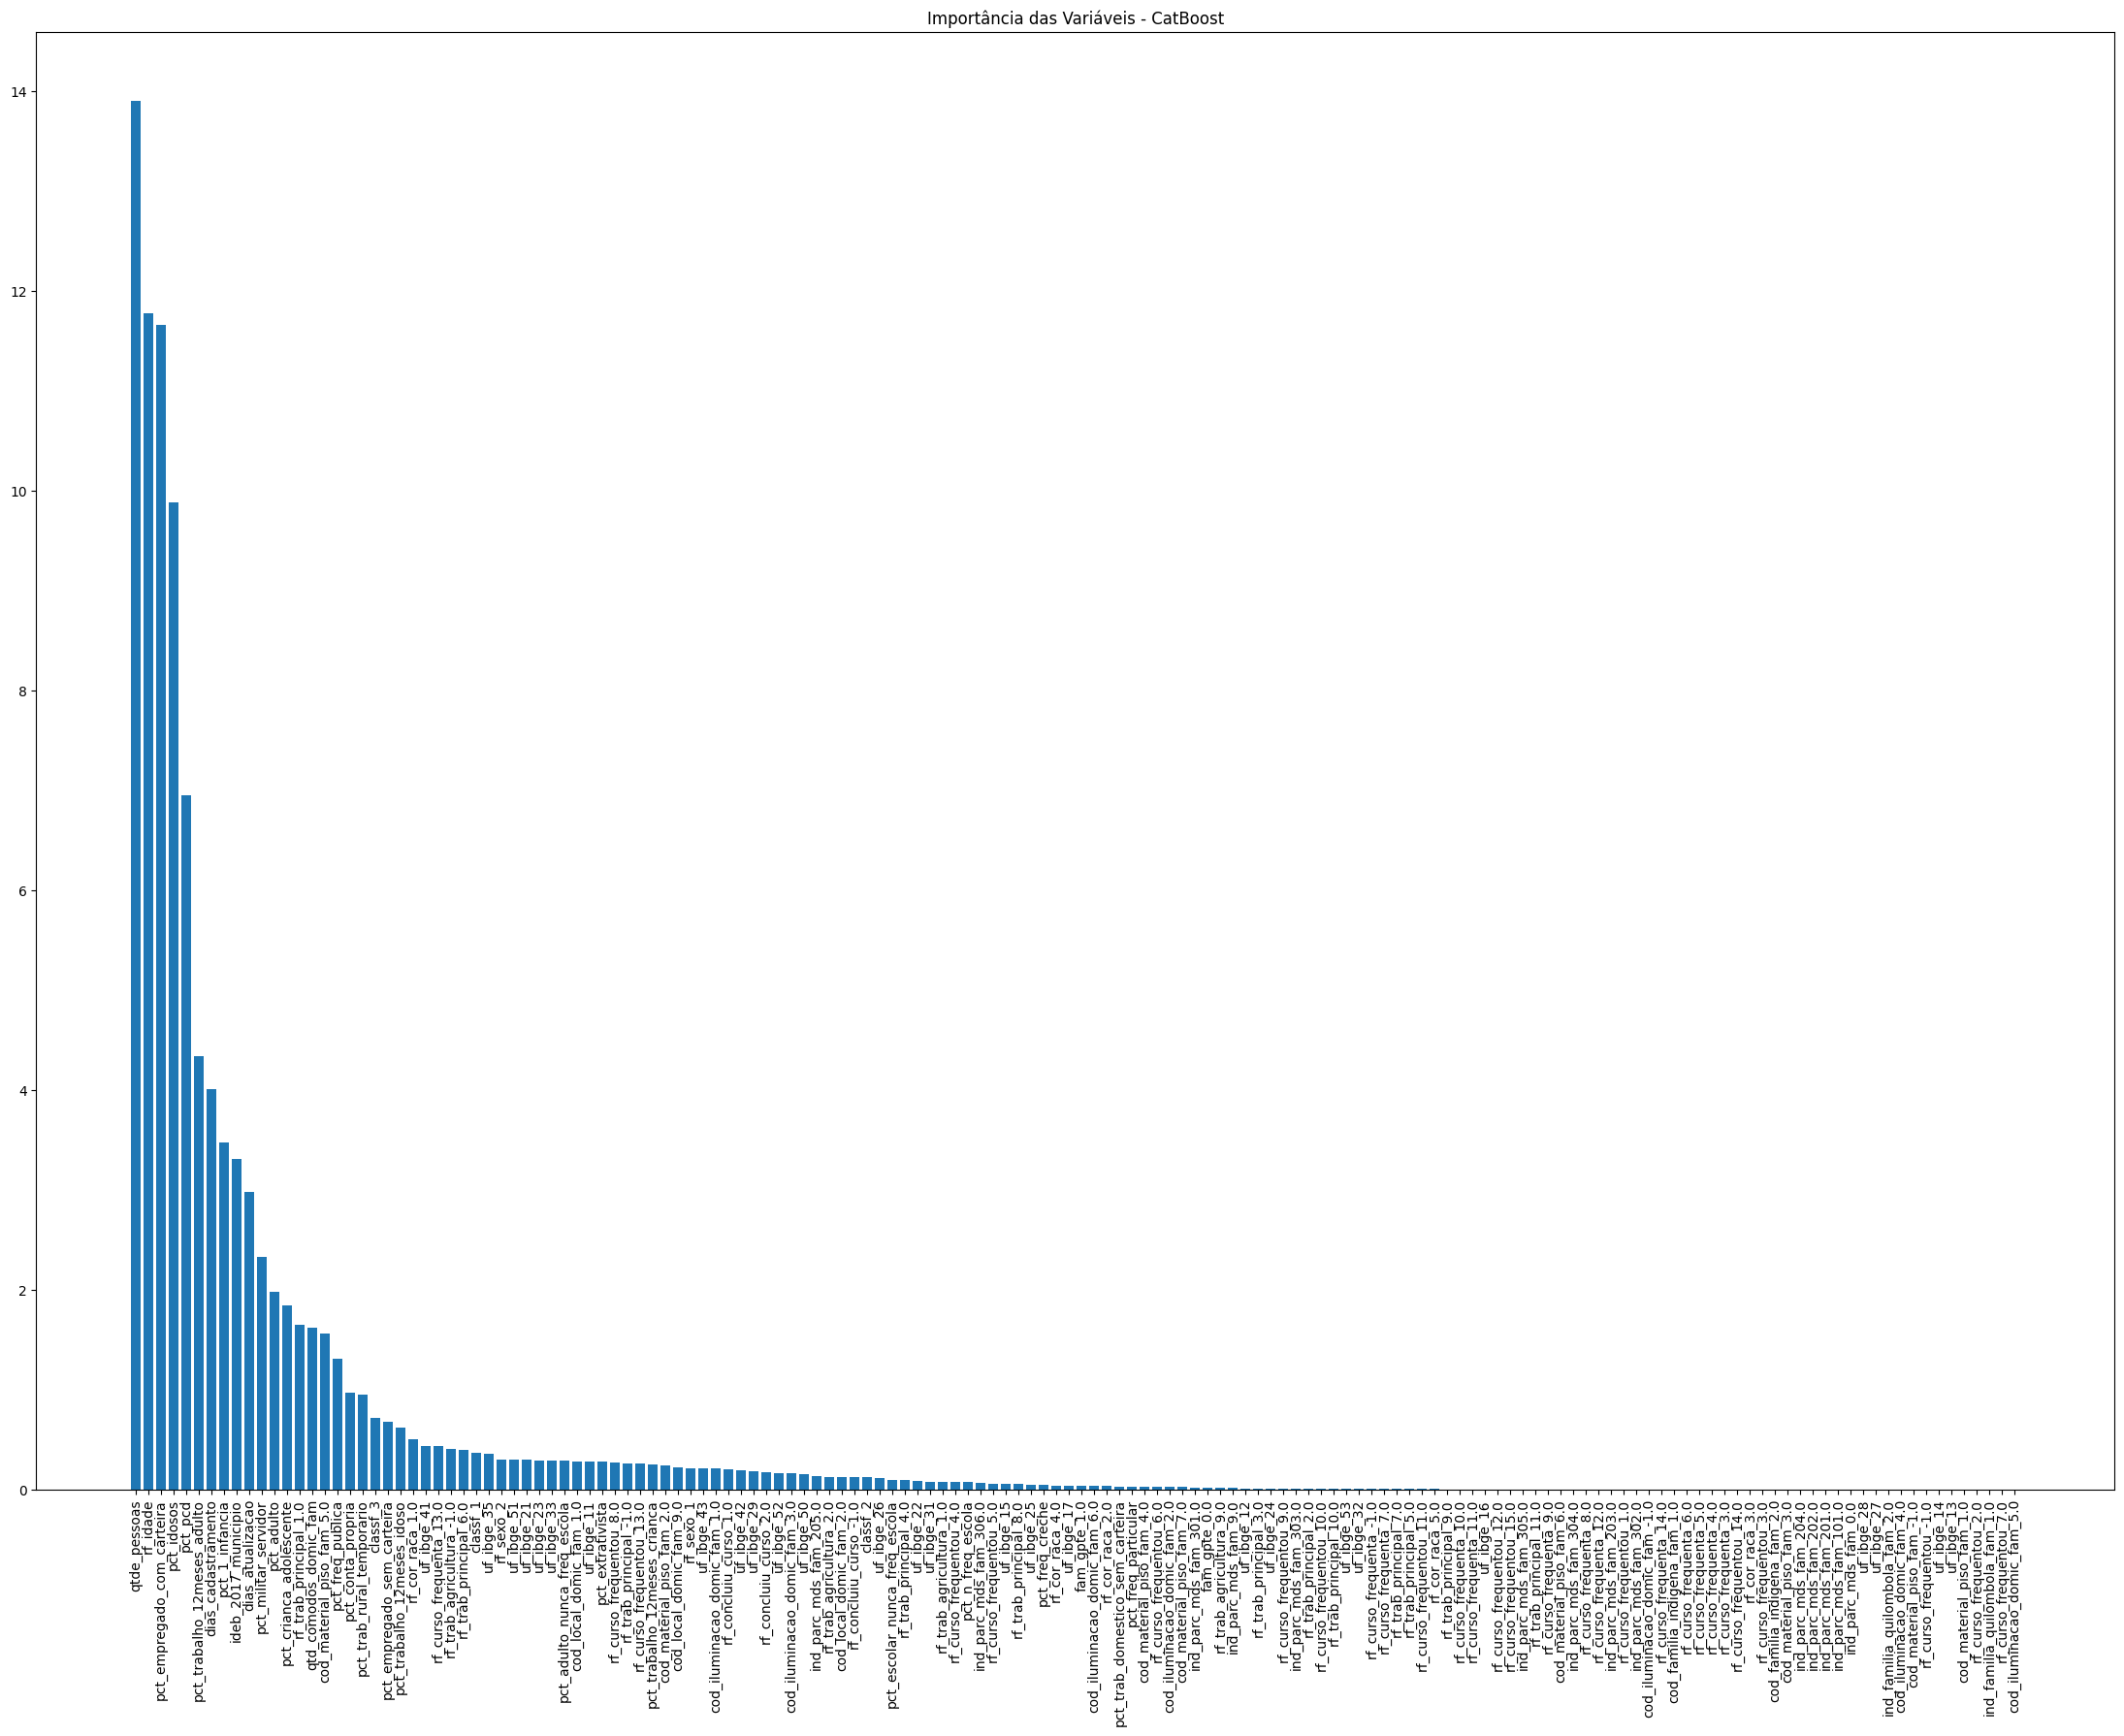

In [29]:
# Exibir as importâncias das variáveis
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        median_importance = np.median(importances)
        important_features = np.where(importances >= median_importance)[0]
        
        # Mostrar a mediana das importâncias
        print(f"Mediana das importâncias para {name}: {median_importance}")
        
        # Gráfico de barras mostrando as variáveis mais importantes
        plt.figure(figsize=(22, 18))
        indices = np.argsort(importances)[::-1]  # Ordenar as importâncias de forma decrescente
        plt.title(f'Importância das Variáveis - {name}')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), np.array(processed_columns)[indices], rotation=90)
        plt.tight_layout()
        plt.show()

In [30]:
# Re-treinar o modelo após a remoção das variáveis menos importantes
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        median_importance = np.median(importances)
        important_features = np.where(importances >= median_importance)[0]

        # Remover variáveis menos importantes e re-treinar
        X_train_filtered = X_train_preprocessed[:, important_features]
        X_test_filtered = X_test_preprocessed[:, important_features]
        
        print(f"Treinando novamente {name} com variáveis acima da mediana...")
        opt.best_estimator_.fit(X_train_filtered, y_train)
        y_pred_filtered = opt.best_estimator_.predict(X_test_filtered)
        print(f"Resultados após remover variáveis abaixo da mediana para {name}:")
        print(classification_report(y_test, y_pred_filtered))

Treinando novamente RandomForest com variáveis acima da mediana...
Resultados após remover variáveis abaixo da mediana para RandomForest:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      9541
           1       0.69      0.65      0.67      9707
           2       0.81      0.80      0.80      9790

    accuracy                           0.75     29038
   macro avg       0.75      0.75      0.75     29038
weighted avg       0.75      0.75      0.75     29038

Treinando novamente XGBoost com variáveis acima da mediana...
Resultados após remover variáveis abaixo da mediana para XGBoost:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      9541
           1       0.69      0.65      0.67      9707
           2       0.81      0.80      0.80      9790

    accuracy                           0.75     29038
   macro avg       0.75      0.75      0.75     29038
weighted avg       0.75    

In [31]:
# Realizar o re-treinamento com as top 10 variáveis mais importantes
for name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Obter os índices das 10 variáveis mais importantes
        top_10_indices = np.argsort(importances)[-10:]  # Pegar as últimas 10 maiores importâncias
        
        # Exibir as 10 variáveis mais importantes
        top_10_features = np.array(processed_columns)[top_10_indices]
        print(f"As 10 variáveis mais importantes para {name}: {top_10_features}")
        
        # Filtrar o conjunto de treino e teste com as 10 variáveis mais importantes
        X_train_top_10 = X_train_preprocessed[:, top_10_indices]
        X_test_top_10 = X_test_preprocessed[:, top_10_indices]
        
        # Re-treinar o modelo com as top 10 variáveis
        print(f"Re-treinando {name} com as 10 variáveis mais importantes...")
        opt.best_estimator_.fit(X_train_top_10, y_train)
        
        # Fazer as previsões no conjunto de teste filtrado
        y_pred_top_10 = opt.best_estimator_.predict(X_test_top_10)
        
        # Exibir o relatório de classificação
        print(f"Resultados após re-treinar {name} com as top 10 variáveis:")
        print(classification_report(y_test, y_pred_top_10))

As 10 variáveis mais importantes para RandomForest: ['ideb_2017_municipio' 'pct_freq_publica' 'pct_1_infancia'
 'dias_cadastramento' 'pct_pcd' 'pct_empregado_com_carteira'
 'qtde_pessoas' 'pct_adulto' 'rf_idade' 'pct_idosos']
Re-treinando RandomForest com as 10 variáveis mais importantes...
Resultados após re-treinar RandomForest com as top 10 variáveis:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      9541
           1       0.67      0.57      0.62      9707
           2       0.75      0.78      0.76      9790

    accuracy                           0.71     29038
   macro avg       0.71      0.71      0.70     29038
weighted avg       0.71      0.71      0.70     29038

As 10 variáveis mais importantes para XGBoost: ['pct_1_infancia' 'rf_trab_principal_4.0' 'cod_material_piso_fam_5.0'
 'rf_trab_principal_1.0' 'pct_militar_servidor' 'pct_adulto' 'pct_pcd'
 'qtde_pessoas' 'pct_empregado_com_carteira' 'pct_idosos']
Re-treinando XG

In [39]:
# Seleção com Recursive Feature Elimination (RFE)
num_features_to_select = 10  # Número de variáveis que queremos selecionar

for name, model in models.items():
    rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)
    rfe.fit(X_train_preprocessed, y_train)
    
    # Selecionar as variáveis mais importantes
    important_indices = np.where(rfe.support_)[0]
    important_features = np.array(processed_columns)[important_indices]
    print(f"As variáveis mais importantes para {name} com RFE: {important_features}")
    
    # Filtrar os dados
    X_train_filtered = X_train_preprocessed[:, important_indices]
    X_test_filtered = X_test_preprocessed[:, important_indices]
    
    # Re-treinar o modelo
    print(f"Re-treinando {name} com as variáveis selecionadas pelo RFE...")
    model.fit(X_train_filtered, y_train)
    y_pred_filtered = model.predict(X_test_filtered)
    
    # Exibir o relatório de classificação
    print(f"Resultados após re-treinar {name} com as variáveis selecionadas pelo RFE:")
    print(classification_report(y_test, y_pred_filtered))

KeyboardInterrupt: 